# Path integral tutorial

In this tutorial, we numerically solve for "optimal" paths according to the **Onsager-Machlup (OM)** functional (see [Chen et al., 2019](https://aip.scitation.org/doi/abs/10.1063/1.5083973)). The purpose is to lightly highlight some applications from dynamical systems, stochastic processes, and optimization. We will need the following Julia packages:

In [1]:
using Random, DifferentialEquations, Zygote, Optim, Plots, LaTeXStrings

## Dynamical systems

Let's first consider the **stochastic differential equation (SDE)**

$$
\text{d}X_t = f(X_t,t)\, \text{d}t + \sigma\, \text{d}W_t,
$$

where

$$
f(x,t) = \frac{1}{\epsilon}\left(x-x^3+\alpha+A\cos(2\pi t)\right),
$$

and, by extension,

$$
f_x(x,t) = \frac{1}{\epsilon}\left(1-3x^2\right).
$$

In [2]:
# Dynamics
f(x,(ϵ,A,α),t) = 1/ϵ*(x-x^3+α+A*cos(2*π*t))    # deterministic
fₓ(x,(ϵ,A,α),t) = 1/ϵ*(1-3*x^2)    # x-partial of f (for Lagrangian)
g(x,(ϵ,A,α),t) = σ    # stochastic

g (generic function with 1 method)

The deterministic dynamics $\dot{x} = f(x,t)$ is characterized by two stable orbits $a(t)$ and $b(t)$, as well as an unstable orbit $c(t)$ in between. (Note that these are *not* the same as the nullclines $\dot{x} = 0$.)

We will use the pacakge `DifferentialEquations` to integrate the **ordinary differential equation (ODE)** in (forward and reverse) time to solve and visualize the (stable and unstable) orbits.

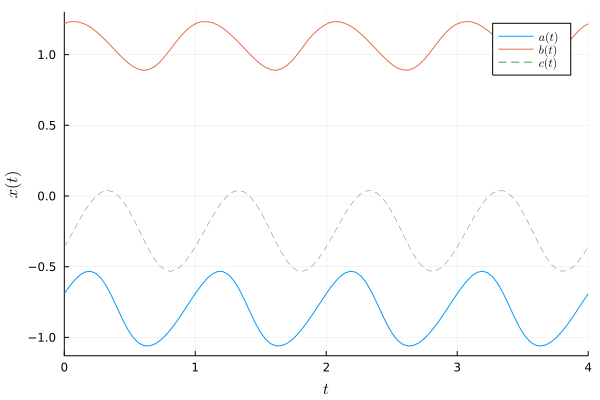

In [17]:
# Time domain
τ0,τf = -10,14    # extended time for ODE solver
tspan = Float64.((τ0,τf))
t0,tf = 0,4    # time span for plots
Nt = 100
t = range(t0,tf,length=Nt)
Δt = (tf-t0)/(Nt-1)

# Initial conditions
a0,b0,c0 = -1,1,0

# Parameters
θ = (ϵ,A,α) = (0.25,0.5,0.2)

# Solve ODEs
a = solve(ODEProblem(f,a0,tspan,θ))
b = solve(ODEProblem(f,b0,tspan,θ))
c = solve(ODEProblem(f,c0,reverse(tspan),θ))

# Plot solutions
plt = plot(t,[a(t) b(t) c(t)],style=[:solid :solid :dash],width=[1 1 0.5],xlims=(t0,tf),xlabel=L"t",ylabel=L"x(t)",label=false,fmt=:png)
plt1 = plot(plt)
plt1[1][1][:label],plt1[1][2][:label],plt1[1][3][:label] = L"a(t)",L"b(t)",L"c(t)"
display(plt1)

## Stochastic processes

Next we visualize the SDE solutions by solving $N=50$ instances from $(x_0,t_0) = (a(0.25),0.25)$, with additive noise $\sigma=0.5$.

Again, we use `DifferentialEquations` to integrate the now-stochastic dynamics forward, highlighting the solutions that cross the upper orbit $b(t)$ before time $t_f = 4$.

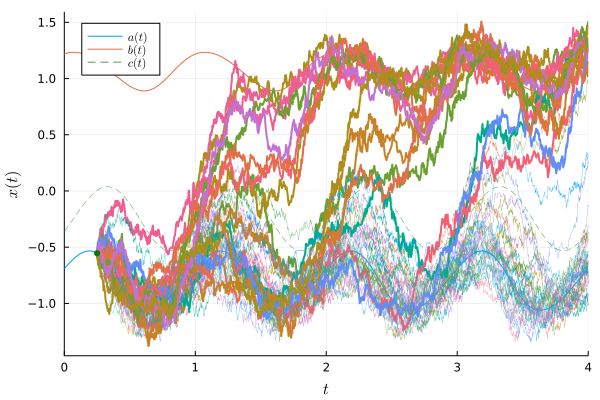

In [18]:
# Initial condition
t1 = 0.25; x1 = a(t1)    # (x₀,t₀) above
t̃span = Float64.((t1,tf))

# Noise parameter
σ = 0.5

# Solve SDE N times
N = 50
Random.seed!(1234)
prob = SDEProblem(f,g,x1,t̃span,θ)
Xₜ = [solve(prob) for i ∈ 1:N]

# Plot solutions
plt2 = plot(plt1,legend=:topleft)
for xₜ ∈ Xₜ
    if any(xₜ.u .≥ b(xₜ.t)) lw = 2 else lw = 0.25 end
    plt2 = plot!(xₜ.t,xₜ.u,width=lw,label=false)
end
plt2 = scatter!([t1],[x1],color=:green,markerstrokewidth=false,label=false)
display(plt2)

## Optimization

To compute the OM-optimal paths, we define the **action** of a particular path from $(x_0,t_0)$ to $(x_f,t_f)$ as the functional

$$
S[x] = \int_{t_0}^{t_f}\text{d}t\, L(x(t),\dot{x}(t),t)
$$

with the corresponding **Lagrangian** defined as the function

$$
L(x,\dot{x},t) = \underbrace{\frac{1}{2}\left(\frac{\dot{x}-f(x,t)}{\sigma}\right)^2}_{L_{\text{OM}_1}=\frac{L_\text{FW}}{\sigma^2}} + \underbrace{\frac{1}{2}f_x(x,t)}_{L_{\text{OM}_2}}.
$$

These can be discretized as:

In [11]:
# Lagrangian
L((xₙ₋₁,xₙ),(tₙ₋₁,tₙ),θ,σ) = 1/2*(((xₙ-xₙ₋₁)/(tₙ-tₙ₋₁)-f(xₙ₋₁,θ,tₙ₋₁))/σ)^2 + 1/2*fₓ(xₙ₋₁,θ,tₙ₋₁)

# Action
function S(x,t,(x0,t0),(xf,tf),θ,σ)
    x,t = [x0;x;xf],[t0;t;tf]
    Nt = length(t); Δt = (tf-t0)/(Nt-1)
    X,T = [x[n-1:n] for n ∈ 2:Nt],[t[n-1:n] for n ∈ 2:Nt]
    
    return Δt*sum(L.(X,T,Ref(θ),σ))
end

S (generic function with 1 method)

As before, we start from $(x_0,t_0) = (a(0.25),0.25)$. We now also set $(x_f,t_f) = (b(4),4)$ to consider action-minimizing paths that traverse from the lower orbit to the upper one within four periods.

To implement this, we use the `Optim` nonlinear optimization package and initialize a "guess" path $\hat{x}(t) = \frac{x_f-x_0}{t_f-t_0}(t-t_0)+x_0$. We minimize the discretized action functional $S$ with respect to the vector $\textbf{x} = (x(t_0+\Delta t),\dots,x(t_f-\Delta t))$, using the L-BFGS method (which approximates a Hessian and requires a gradient&mdash;provided by (reverse-mode) auto-differentiation by passing the `Zygote`-computed gradient).

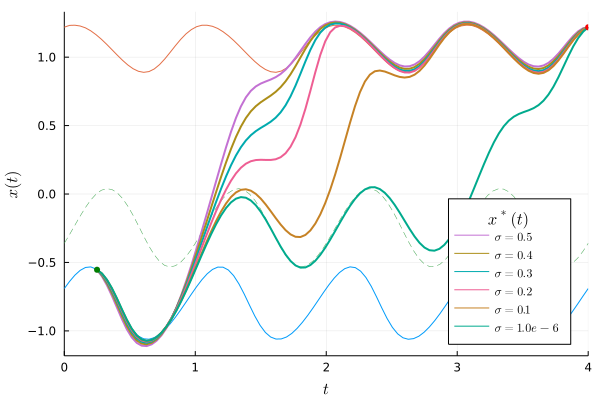

In [19]:
# Time domain
Nt̃ = 100
t̃ = range(t1,tf,length=Nt̃)
Δt̃ = (tf-t1)/(Nt̃-1)

# Noise parameters
Σ = [0.5,0.4,0.3,0.2,0.1,1e-6]

# Solve NLP
xf = b(tf)
x̂ = collect(range(x1,xf,length=Nt̃)[2:end-1])
X̃ = []
for σ ∈ Σ
    s = x -> S(x,t̃[2:end-1],(x1,t1),(xf,tf),θ,σ)
    function ∇s!(∇s,x) ∇s .= s'(x) end    # this step uses Zygote
    x̃ = [x1;Optim.minimizer(optimize(s,∇s!,x̂,LBFGS()));xf]
    push!(X̃,x̃)
end

# Plot solutions
plt3 = plot(plt,legendtitle=L"x^*(t)",legend=:bottomright)
for (x̃,σ) ∈ zip(X̃,Σ) plt3 = plot!(t̃,x̃,label=L"\sigma=%$(σ)",width=2) end
plt3 = scatter!([t1,tf],[x1,xf],color=[:green,:red],markerstrokewidth=false,label=false)
display(plt3)

We can note that, as the noise level $\sigma$ tends to zero, the optimal path "follows" the unstable orbit $c(t)$ as long as it can before transitioning towards the upper stable orbit $b(t)$.